# Optimizing Stock Portfolio Allocation <a class='tocSkip'>

## Sang-Yun Oh <a class='tocSkip'>

## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/cvxpy/
* Can also install from github repository:  
    `pip install git+https://github.com/cvxgrp/cvxpy/`

In [1]:
# install cvxpy package
!pip install cvxpy

     |████████████████████████████████| 911kB 7.9MB/s eta 0:00:01
     |████████████████████████████████| 215kB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 153kB 11.7MB/s eta 0:00:01
     |████████████████████████████████| 163kB 12.2MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 11.4MB/s eta 0:00:01
     |████████████████████████████████| 829kB 11.3MB/s eta 0:00:01
     |████████████████████████████████| 153kB 11.3MB/s eta 0:00:01
  Created wheel for cvxpy: filename=cvxpy-1.0.25-cp37-cp37m-linux_x86_64.whl size=2104392 sha256=17a10f4a4ff4cd4c8d45e28c8f29bf229c43168dc9126bbcca2db70ed599bd61
  Stored in directory: /home/jovyan/.cache/pip/wheels/f1/b0/c3/0d3e98435c5070047e033ead500eb4f93a87c4f3ab6ea6dc1e
  Created wheel for scs: filename=scs-2.1.1.post2-cp37-cp37m-linux_x86_64.whl size=507000 sha256=23a18b5265d9999b5bffc1fa2ca600d9842619ae65f179079b95b2b87b93ddd8
  Stored in directory: /home/jovyan/.cache/pip/wheels/68/3f/24/e9c75d426f600634cdac68321184ba0

In [2]:
# ! pip install git+https://github.com/cvxgrp/cvxpy/

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [4]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [5]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [6]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0296
cor(R_A, R_B) = -0.8994


### Empirical Portfolio Returns

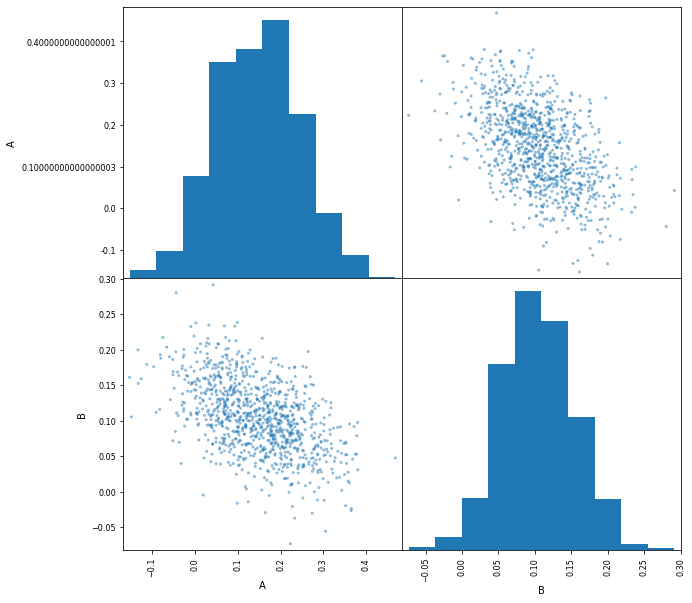

In [7]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [8]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [9]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig']))
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


#### Empirical (Data) Properties 

In [10]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.0997
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0294
corr(A, B) = -0.9002


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [11]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

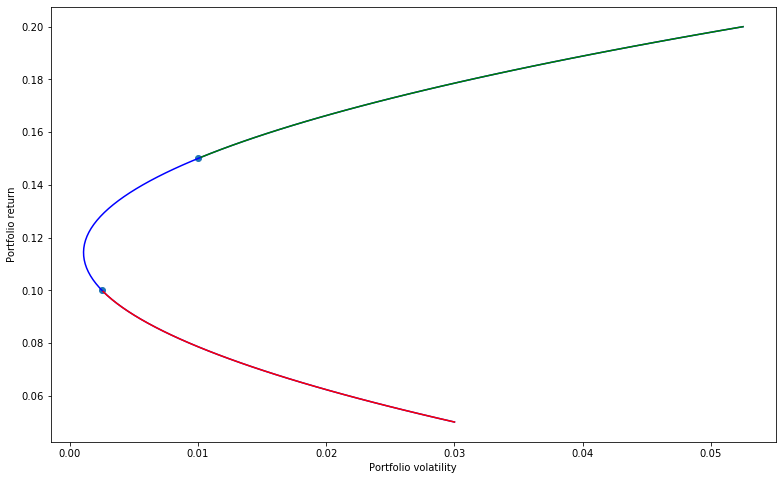

In [12]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$ x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1} $$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

In [16]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DWDP','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','UTX','VZ','WMT','XOM']
symbols = pd.read_csv('data/tickers.csv').set_index('code')
symbols.loc[dowjones_components]

,name,refreshed_at,from_date,to_date
code,,,,
AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and...",2018-03-27 21:46:10,1980-12-12,2018-03-27
AXP,"American Express Co. (AXP) Prices, Dividends, ...",2018-03-27 21:46:10,1972-06-01,2018-03-27
BA,"The Boeing Co. (BA) Prices, Dividends, Splits ...",2018-03-27 21:46:10,1962-01-02,2018-03-27
BAC,"Bank of America Corp. (BAC) Prices, Dividends,...",2018-03-27 21:46:10,1986-05-29,2018-03-27
CAT,"Caterpillar Inc. (CAT) Prices, Dividends, Spli...",2018-03-27 21:46:10,1962-01-02,2018-03-27
CSCO,"Cisco Systems Inc. (CSCO) Prices, Dividends, S...",2018-03-27 21:46:10,1990-03-26,2018-03-27
CVX,"Chevron Corporation (CVX) Prices, Dividends, S...",2018-03-27 21:46:10,1970-01-02,2018-03-27
DD,"E.I. du Pont de Nemours and Co. (DD) Prices, D...",2017-08-31 21:48:17,1962-01-02,2017-08-31
DWDP,Untitled Dataset 2017-09-01 21:48:13,2018-03-27 21:46:10,2017-09-01,2018-03-27


In [18]:
# uncomment next line if quandl is not installed
# ! pip install quandl

import quandl
import myapikeys as m

quandl.ApiConfig.api_key = m.apikeys['quandl']

data = quandl.get_table(
    'WIKI/PRICES', 
    qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
    date = { 'gte': '2000-01-01', 'lte': '2018-05-01' },
    ticker = dowjones_components,
    paginate=True)

data.set_index('date', inplace=True)

In [19]:
data.head()

,ticker,adj_close
date,,
2018-03-27,XOM,73.70
2018-03-26,XOM,74.00
2018-03-23,XOM,72.89
2018-03-22,XOM,73.50
2018-03-21,XOM,75.04


Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies until 2017-08-31 so all 30 stocks can be included. Note that this is not the same as the Dow Jones Index throughout the time period since some symbols have entered the DJIA later than year 2000: e.g., Verizon was added in 2004.

We have set the index to be 'date' column. For the next line, unset datetime index in order to operate on the column:

In [20]:
data['ticker'].unique()

array(['XOM', 'WMT', 'VZ', 'UTX', 'TRV', 'T', 'PG', 'PFE', 'MSFT', 'MRK',
       'MMM', 'MCD', 'KO', 'JPM', 'JNJ', 'INTC', 'IBM', 'HPQ', 'HD', 'GE',
       'DWDP', 'DIS', 'DD', 'CVX', 'CSCO', 'CAT', 'BAC', 'BA', 'AXP',
       'AAPL'], dtype=object)

In [21]:
data_range = data.reset_index().groupby('ticker')['date'].agg([min, max])
data_range

,min,max
ticker,,
AAPL,2000-01-03,2018-03-27
AXP,2000-01-03,2018-03-27
BA,2000-01-03,2018-03-27
BAC,2000-01-03,2018-03-27
CAT,2000-01-03,2018-03-27
CSCO,2000-01-03,2018-03-27
CVX,2000-01-03,2018-03-27
DD,2000-01-03,2017-08-31
DIS,2000-01-03,2018-03-27


#### Subsetting date ranges with datetime index
Setting `date` column as the index is useful for time series data. The row index can be used to subset the data:

### Long to wide-format data

Since we will compute the covariance matrix, turn the data into long format

In [22]:
datawide = data.reset_index().pivot(index='date',columns='ticker',values='adj_close')
datawide = datawide['2000-01-03':'2017-08-31']
datawide.drop(['DWDP'], axis=1, inplace=True)
datawide

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.596463,36.138984,27.180308,14.971243,14.984244,44.665571,22.618476,34.188903,23.839401,29.005613,...,34.119980,38.796484,17.492344,33.642761,19.767236,20.993866,21.919553,24.211294,48.716786,24.854185
2000-01-04,3.293170,34.771563,27.139731,14.081128,14.790123,42.145127,22.618476,34.188903,25.235618,27.845388,...,32.919248,37.485073,16.839399,32.983714,18.610642,20.713948,21.021728,23.427678,46.893826,24.378112
2000-01-05,3.341362,34.593453,29.040120,14.235662,15.347834,42.475677,23.108007,35.666916,26.129196,27.797045,...,34.432776,37.881159,17.146668,32.701266,18.820932,20.917525,20.825329,24.211294,45.800050,25.590512
2000-01-06,3.052206,34.593453,29.121276,15.453389,15.908626,41.318752,24.003225,37.607794,25.235618,28.168317,...,34.498363,36.613017,17.728282,33.862443,18.502869,20.955695,21.589883,24.088096,46.441732,27.037774
2000-01-07,3.196784,35.076795,29.966645,15.048510,16.426281,43.756559,24.425141,37.676171,24.836699,29.258928,...,37.807945,37.092315,18.929921,36.561396,18.663579,21.789088,22.445622,23.909214,49.949107,26.958428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-25,159.860000,85.143101,234.621774,23.651100,114.669109,31.169689,108.230000,82.660000,102.410000,24.246823,...,62.495762,72.453281,33.089189,91.818280,37.513667,125.684336,115.070000,48.680000,78.630000,76.720000
2017-08-28,161.470000,85.083331,235.904839,23.601351,114.390761,31.268829,107.760000,82.880000,102.560000,24.227021,...,62.873080,72.463230,33.168468,91.778579,37.464294,122.464464,115.330000,48.610000,78.030000,76.470000
2017-08-29,162.910000,85.093293,239.197043,23.462051,115.325213,31.209345,107.860000,82.240000,102.570000,24.197319,...,62.674492,72.682122,33.198198,91.629701,37.375422,122.245831,118.700000,48.510000,78.770000,76.450000


### Log returns from stock prices

Stock market data are measured in terms of price per share. We need to compute the returns from the prices. 
Given the prices $P_t$ and $P_{t-1}$ where $t$ indicates time, the return at time $t$ is defined as
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

It is well known that linear approximation of $\log(1+x)\approx x$ when $x$ is small. Since daily returns of stocks are small, we approximate that
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [23]:
logret = np.log(datawide).diff()
logret.head()

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088100,-0.038572,-0.001494,-0.061296,-0.013040,-0.058084,0.000000,0.000000,0.056917,-0.040822,...,-0.035826,-0.034387,-0.038042,-0.019784,-0.060292,-0.013423,-0.041822,-0.032901,-0.038138,-0.019340
2000-01-05,0.014528,-0.005135,0.067680,0.010915,0.037015,0.007813,0.021412,0.042322,0.034797,-0.001738,...,0.044951,0.010511,0.018083,-0.008600,0.011236,0.009780,-0.009387,0.032901,-0.023601,0.048536
2000-01-06,-0.090514,0.000000,0.002791,0.082078,0.035887,-0.027615,0.038009,0.052988,-0.034797,0.013268,...,0.001903,-0.034050,0.033357,0.034893,-0.017044,0.001823,0.036055,-0.005101,0.013913,0.055013
2000-01-07,0.046281,0.013875,0.028616,-0.026549,0.032021,0.057325,0.017425,0.001817,-0.015934,0.037987,...,0.091607,0.013006,0.065583,0.076686,0.008648,0.038999,0.038871,-0.007454,0.072806,-0.002939


Note that the first time period is NaN since there is no data corresponding to $-1$.

Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [24]:
mu = logret[1:].mean()
mu

ticker
AAPL    0.000855
AXP     0.000194
BA      0.000489
BAC     0.000105
CAT     0.000462
CSCO   -0.000076
CVX     0.000351
DD      0.000202
DIS     0.000325
GE     -0.000040
HD      0.000264
HPQ    -0.000012
IBM     0.000114
INTC    0.000038
JNJ     0.000338
JPM     0.000263
KO      0.000210
MCD     0.000416
MMM     0.000426
MRK     0.000139
MSFT    0.000146
PFE     0.000147
PG      0.000225
T       0.000141
TRV     0.000384
UTX     0.000382
VZ      0.000154
WMT     0.000106
XOM     0.000252
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [25]:
sigma = logret.cov()
sigma

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000753,0.000211,0.000135,0.000231,0.000190,0.000299,0.000108,0.000130,0.000168,0.000183,...,0.000086,0.000214,0.000082,0.000057,0.000112,0.000133,0.000146,0.000105,0.000096,0.000106
AXP,0.000211,0.000523,0.000203,0.000448,0.000247,0.000248,0.000167,0.000222,0.000237,0.000272,...,0.000142,0.000201,0.000148,0.000103,0.000161,0.000228,0.000208,0.000150,0.000129,0.000157
BA,0.000135,0.000203,0.000360,0.000223,0.000181,0.000161,0.000128,0.000162,0.000166,0.000174,...,0.000105,0.000139,0.000109,0.000079,0.000106,0.000139,0.000197,0.000098,0.000095,0.000126
BAC,0.000231,0.000448,0.000223,0.000899,0.000289,0.000261,0.000198,0.000259,0.000243,0.000328,...,0.000149,0.000208,0.000169,0.000113,0.000171,0.000266,0.000223,0.000155,0.000124,0.000176
CAT,0.000190,0.000247,0.000181,0.000289,0.000413,0.000192,0.000170,0.000223,0.000179,0.000210,...,0.000111,0.000163,0.000118,0.000087,0.000120,0.000163,0.000199,0.000111,0.000104,0.000157
CSCO,0.000299,0.000248,0.000161,0.000261,0.000192,0.000630,0.000120,0.000170,0.000210,0.000217,...,0.000094,0.000269,0.000104,0.000070,0.000133,0.000162,0.000176,0.000132,0.000113,0.000118
CVX,0.000108,0.000167,0.000128,0.000198,0.000170,0.000120,0.000260,0.000148,0.000133,0.000138,...,0.000107,0.000121,0.000106,0.000068,0.000103,0.000132,0.000129,0.000095,0.000068,0.000207
DD,0.000130,0.000222,0.000162,0.000259,0.000223,0.000170,0.000148,0.000318,0.000167,0.000188,...,0.000112,0.000136,0.000117,0.000098,0.000116,0.000151,0.000176,0.000107,0.000100,0.000142
DIS,0.000168,0.000237,0.000166,0.000243,0.000179,0.000210,0.000133,0.000167,0.000370,0.000193,...,0.000109,0.000166,0.000110,0.000076,0.000123,0.000148,0.000167,0.000124,0.000102,0.000126


### Visualize volatility structure

We can visualize the relationship between the stocks by a heatmap.

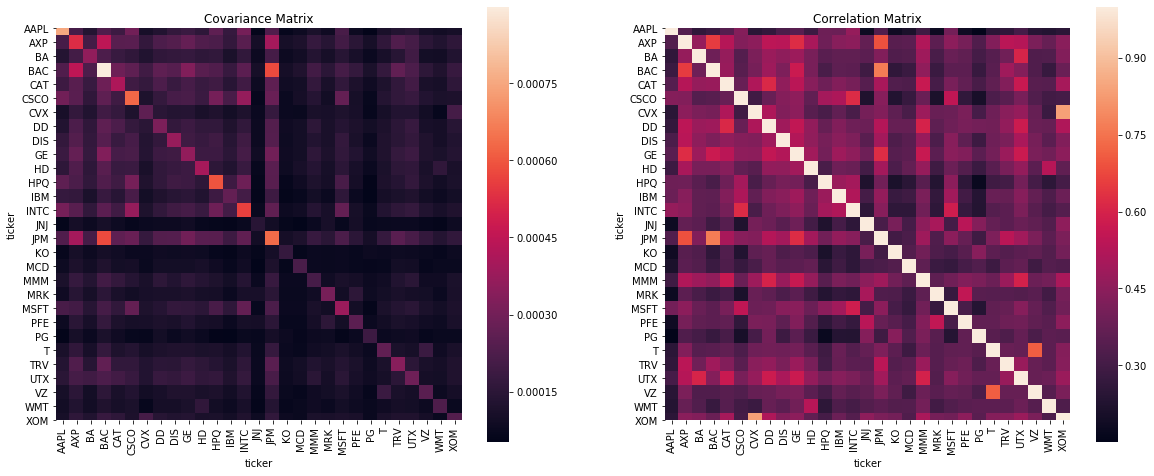

In [65]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

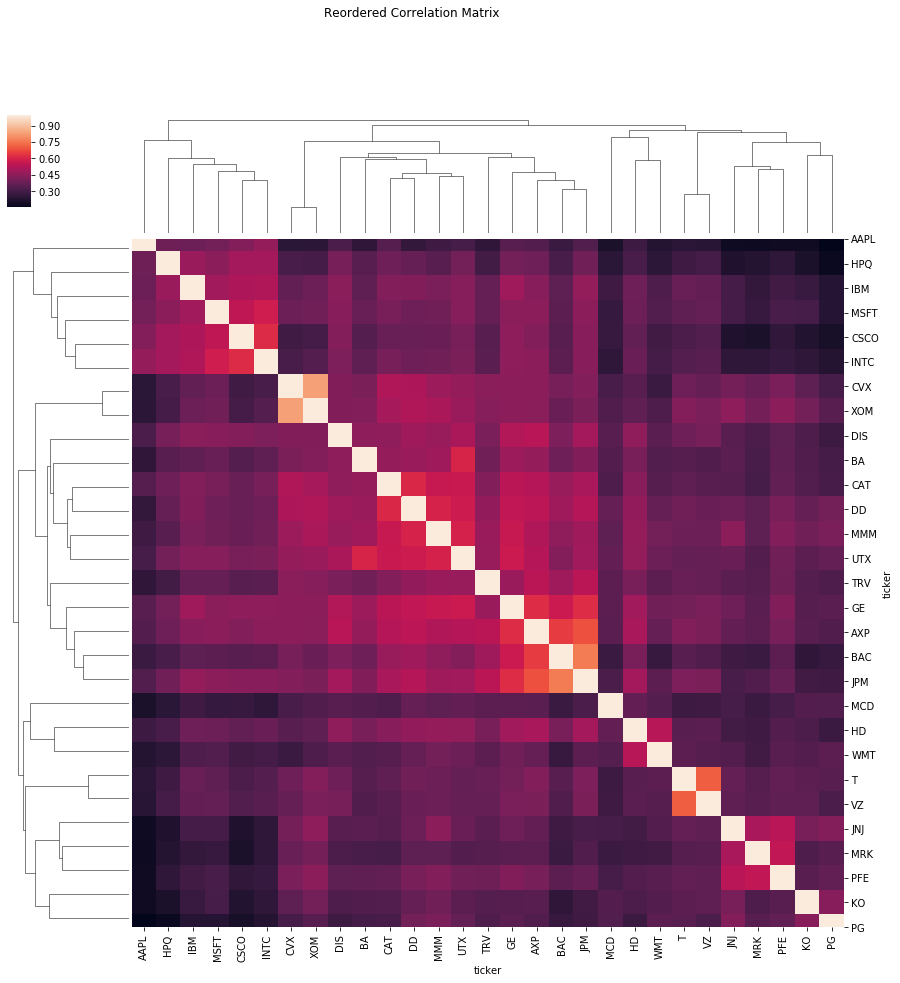

In [64]:
sns.clustermap(logret.corr(), square=True, figsize=(15, 15)).fig.suptitle('Reordered Correlation Matrix');

In [27]:
import cvxpy as cvx

s, _ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum(w) == 1])
prob.solve()
w.value

array([ 0.01948105, -0.06250038,  0.01187498, -0.0084919 , -0.02646181,
       -0.01481032,  0.09051826, -0.02578476, -0.00523808, -0.02671965,
       -0.01710607,  0.01275726,  0.12379533, -0.01863563,  0.23961134,
       -0.04051534,  0.1516256 ,  0.14640105,  0.09242141, -0.00409392,
        0.02276257,  0.02262697,  0.12819021,  0.0148031 ,  0.01603381,
       -0.00239166,  0.07525989,  0.11741913, -0.03283244])

Examples for portfolio optimization: http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

Even though a much more difficult problem to solve, we can use `cvxpy` package to solve optimization problems easily. Let's try to solve the more difficult problem with a target expected return:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

In [28]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values*w >= 0.001
               ])
prob.solve()
w.value

array([ 0.28292044, -0.08692003,  0.18889568, -0.11475068,  0.12405921,
       -0.14578946,  0.28568954, -0.15833925,  0.08717126, -0.40742057,
        0.01603534, -0.10958107,  0.0155148 , -0.09567277,  0.4877874 ,
        0.12581918,  0.02407474,  0.32872418,  0.40772487, -0.11240587,
       -0.00764719, -0.08230916,  0.07441161, -0.05895637,  0.12938975,
        0.08051488,  0.0551157 , -0.08624538, -0.24781079])

Verify that the solution satisfies the constraints: i.e. $\mu^\intercal w=0.001$ and $\mathbf{1}^\intercal w=1$.

In [29]:
w.value.sum()

1.0

In [30]:
np.dot(mu.values,w.value)

0.0009999999999999996

### Making the investment

Taking the allocation `w.value`, we can compute portfolio returns using the historical market returns: `logret`.

In [31]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)

`fillna()` method "back-fills" missing values:

In [32]:
logret.fillna(method='bfill').head()

ticker,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.088100,-0.038572,-0.001494,-0.061296,-0.013040,-0.058084,0.000000,0.000000,0.056917,-0.040822,...,-0.035826,-0.034387,-0.038042,-0.019784,-0.060292,-0.013423,-0.041822,-0.032901,-0.038138,-0.019340
2000-01-04,-0.088100,-0.038572,-0.001494,-0.061296,-0.013040,-0.058084,0.000000,0.000000,0.056917,-0.040822,...,-0.035826,-0.034387,-0.038042,-0.019784,-0.060292,-0.013423,-0.041822,-0.032901,-0.038138,-0.019340
2000-01-05,0.014528,-0.005135,0.067680,0.010915,0.037015,0.007813,0.021412,0.042322,0.034797,-0.001738,...,0.044951,0.010511,0.018083,-0.008600,0.011236,0.009780,-0.009387,0.032901,-0.023601,0.048536
2000-01-06,-0.090514,0.000000,0.002791,0.082078,0.035887,-0.027615,0.038009,0.052988,-0.034797,0.013268,...,0.001903,-0.034050,0.033357,0.034893,-0.017044,0.001823,0.036055,-0.005101,0.013913,0.055013
2000-01-07,0.046281,0.013875,0.028616,-0.026549,0.032021,0.057325,0.017425,0.001817,-0.015934,0.037987,...,0.091607,0.013006,0.065583,0.076686,0.008648,0.038999,0.038871,-0.007454,0.072806,-0.002939


Compute the growth of the portfolio. For each period returns indicate if you lost or gained portfolio value from the day before. 

Hence, to compute the portfolio values of starting from $1:

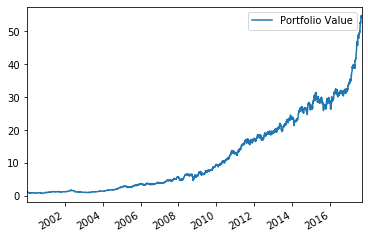

In [33]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot();

### Checking the results

In [34]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max'])
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max'])
print('portfolio average returns:', earned.mean())
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.0010048605202767733
          average stddev : 0.014610560441142811

component stocks average: minimum: -0.000076
                          average: 0.000241
                          maximum: 0.000855
component stocks stddev : minimum: 0.012025
                          average: 0.018827
                          maximum: 0.029984


Annual return would be:

In [66]:
(1+earned.mean())**365 - 1

0.4428061532792895

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [94]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns)

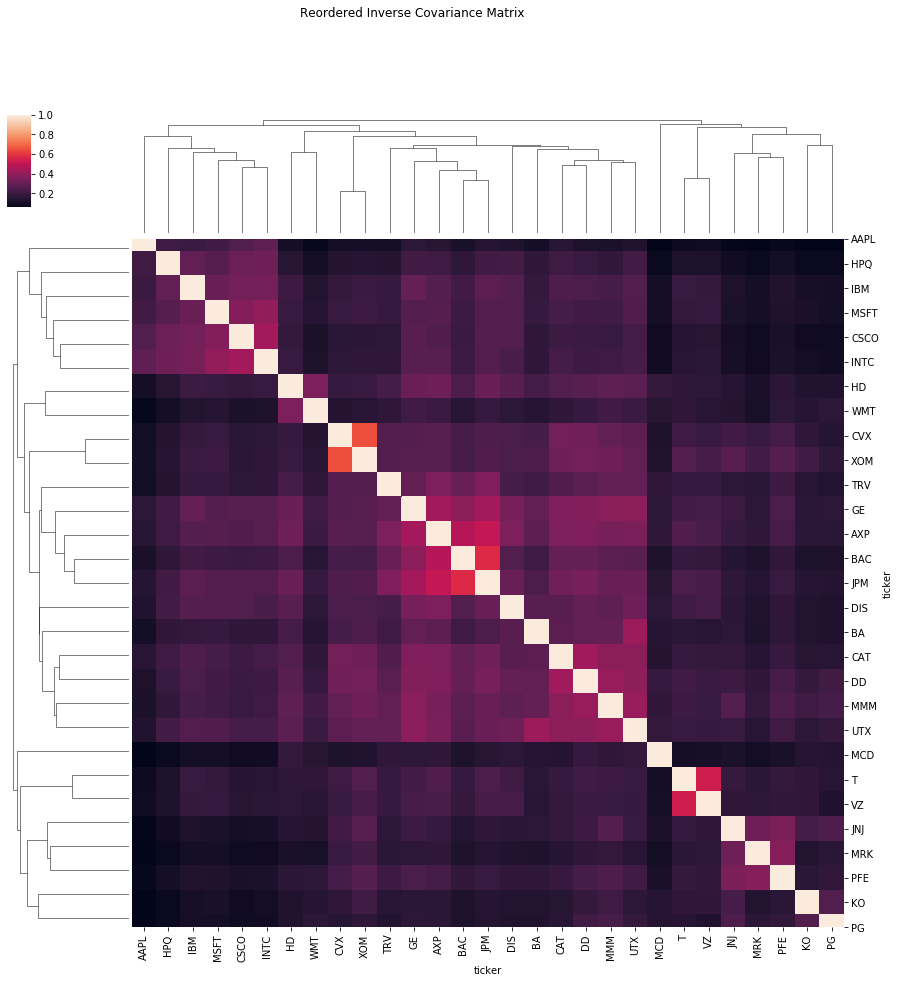

In [99]:
from sklearn.covariance import GraphicalLassoCV
icov = GraphicalLassoCV(cv=10).fit(scaled_df.values)
icovdf = pd.DataFrame(icov.covariance_)
icovdf.columns = logret.columns
icovdf.index = logret.columns
sns.clustermap(icovdf, square=True, figsize=(10, 10)).fig.suptitle('Reordered Inverse Correlation Matrix');

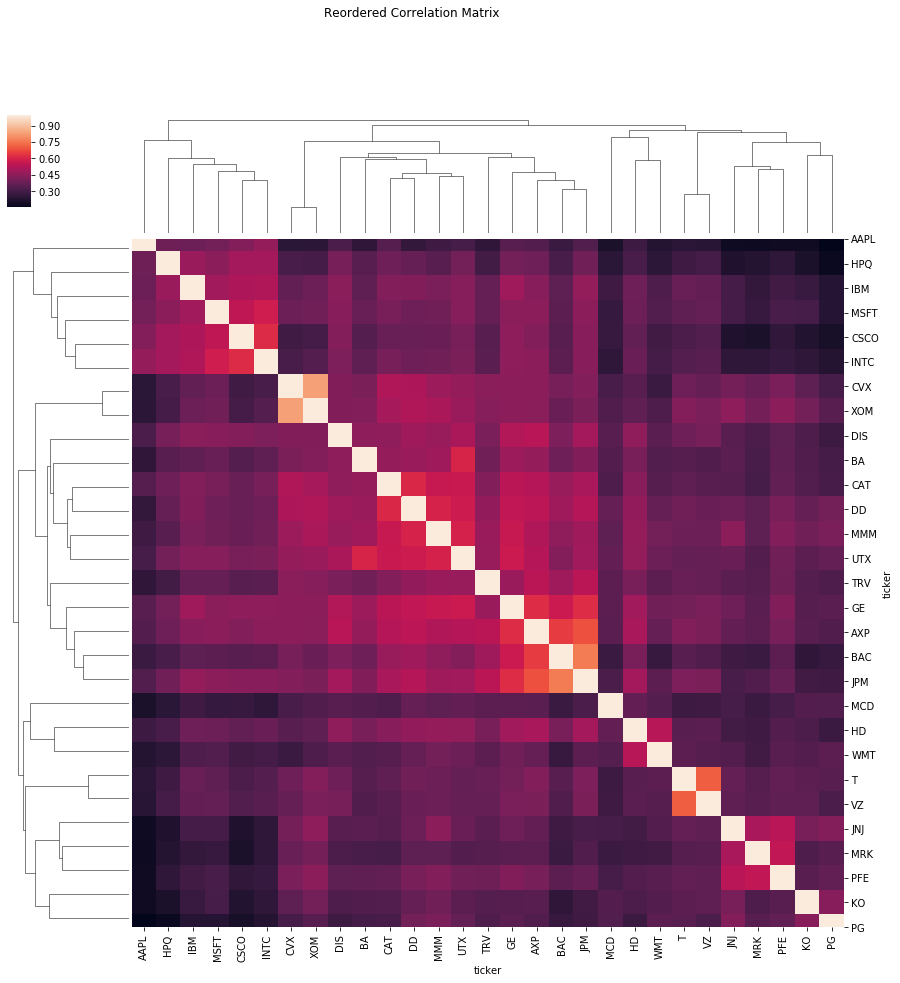

In [100]:
sns.clustermap(logret.corr(), square=True, figsize=(15, 15)).fig.suptitle('Reordered Correlation Matrix');

Is this realistic? Probably not

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!